# League Position Prediction - La Liga
**Important: Run cells sequentially from top to bottom (Shift+Enter or Run All). Each cell depends on variables created by previous cells.**

This notebook predicts the final league standings for La Liga season based on Monte Carlo simulations.

## 1. Setup and Configuration

In [1]:
# Import required libraries
import sys
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path so we can import src module
sys.path.insert(0, "..")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

### Load Configuration

Import the configuration file for your league. Configuration files are stored in the `configs/` directory.

In [2]:
# Load configuration for the league
config_file = "../configs/laliga.yaml"  # Change this to use a different league

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

print(f"League: {config['league']['name']}")
print(f"Country: {config['league']['country']}")
print(f"Season: {config['league']['current_season']}")

League: La Liga
Country: Spain
Season: 2025


## 2. Data Loading and Preparation

Load and prepare match data from the configured sources.

In [3]:
# Import data loading and preprocessing modules
from src.data import (
    load_fixture_csv,
    load_match_statistics,
    normalize_team_names,
    prepare_match_statistics,
)
from src.preprocessing import (
    calculate_home_team_statistics,
    calculate_away_team_statistics,
    calculate_efficiency_metrics,
    calculate_league_table,
)
from src.preprocessing.utils import (
    create_played_matches_dataframe,
    create_remaining_matches_dataframe,
)

# Load fixtures data
fixtures_path = f"../data/raw/{config['data_sources']['all_matches']['filename']}"
fixtures = load_fixture_csv(fixtures_path)

# Normalize team names based on configuration
fixtures = normalize_team_names(fixtures, config.get("team_name_mapping", {}))

print(f"Loaded {len(fixtures)} fixtures")
print(f"Fixtures shape: {fixtures.shape}")
print(f"\nFirst 5 fixtures:")
print(fixtures.head())

Loaded 380 fixtures
Fixtures shape: (380, 7)

First 5 fixtures:
   Match Number  Round Number              Date  \
0             1             1  15/08/2025 17:00   
1             2             1  15/08/2025 19:30   
2             4             1  16/08/2025 17:30   
3             3             1  16/08/2025 19:30   
4             5             1  16/08/2025 19:30   

                         Location         Home Team       Away Team Result  
0  Estadio Municipal de Montilivi         Girona FC  Rayo Vallecano  1 - 3  
1          Estadio de la Cerámica     Villarreal CF     Real Oviedo  2 - 0  
2        Estadi Mallorca Son Moix      RCD Mallorca    FC Barcelona  0 - 3  
3                    Mendizorroza  Deportivo Alavés      Levante UD  2 - 1  
4                Camp de Mestalla       Valencia CF   Real Sociedad  1 - 1  


In [4]:
# Load match statistics
stats_path = f"../data/raw/{config['data_sources']['match_statistics']['filename']}"
statistics = load_match_statistics(stats_path)

# Prepare statistics: standardize columns and normalize team names
statistics = prepare_match_statistics(statistics, config)

print(f"Loaded {len(statistics)} match results")
print(f"Statistics shape: {statistics.shape}")
print(f"\nFirst 5 matches:")
print(statistics.head())

Loaded 219 match results
Statistics shape: (219, 10)

First 5 matches:
         Date         Home Team       Away Team  Home Goals  Away Goals  \
0  15/08/2025         Girona FC  Rayo Vallecano           1           3   
1  15/08/2025     Villarreal CF     Real Oviedo           2           0   
2  16/08/2025      RCD Mallorca    FC Barcelona           0           3   
3  16/08/2025  Deportivo Alavés      Levante UD           2           1   
4  16/08/2025       Valencia CF   Real Sociedad           1           1   

  Result  Home Shots  Away Shots  Home Shots on Target  Away Shots on Target  
0      A           7          16                     2                     5  
1      H          25           5                    10                     4  
2      A           4          24                     1                     8  
3      H          15           7                     4                     3  
4      D          18          13                     2                     3  


In [5]:
# Separate played and remaining matches
played_matches = create_played_matches_dataframe(statistics)
remaining_matches = create_remaining_matches_dataframe(fixtures)

print(f"Played matches: {len(played_matches)}")
print(f"Remaining matches: {len(remaining_matches)}")
print(f"\nRemaining matches sample:")
print(remaining_matches.head())

Played matches: 219
Remaining matches: 161

Remaining matches sample:
        Home Team      Away Team
0      Levante UD  Villarreal CF
1           Celta     CA Osasuna
2  Rayo Vallecano    Real Oviedo
3    FC Barcelona   RCD Mallorca
4      Sevilla FC      Girona FC


## 3. Team Statistics Analysis

Calculate statistics for each team in their home and away performances.

In [6]:
# Calculate home and away team statistics
home_stats = calculate_home_team_statistics(statistics)
away_stats = calculate_away_team_statistics(statistics)

# Calculate efficiency metrics
home_stats, away_stats = calculate_efficiency_metrics(home_stats, away_stats)

print("Home Team Statistics (sorted by attacking efficiency):")
print(
    home_stats.sort_values("home_attack_eff", ascending=False)[
        [
            "avg_home_goals_scored",
            "home_attack_eff",
            "home_defense_eff",
            "home_chance_creation_eff",
            "home_chance_suppression_eff",
        ]
    ].head(10)
)

Home Team Statistics (sorted by attacking efficiency):
                    avg_home_goals_scored  home_attack_eff  home_defense_eff  \
Home Team                                                                      
FC Barcelona                     3.100000         0.154229          0.065789   
Atlético de Madrid               2.363636         0.147727          0.075269   
RCD Mallorca                     1.636364         0.147541          0.092715   
Villarreal CF                    2.090909         0.140244          0.072000   
CA Osasuna                       1.818182         0.138889          0.105691   
Celta                            1.454545         0.131148          0.096296   
Sevilla FC                       1.454545         0.128000          0.165049   
Real Sociedad                    1.636364         0.126761          0.116788   
Elche CF                         1.666667         0.125786          0.075145   
Real Betis                       2.000000         0.123596       

In [7]:
print("\nAway Team Statistics (sorted by attacking efficiency):")
print(
    away_stats.sort_values("away_attack_eff", ascending=False)[
        [
            "avg_away_goals_scored",
            "away_attack_eff",
            "away_defense_eff",
            "away_chance_creation_eff",
            "away_chance_suppression_eff",
        ]
    ].head(10)
)


Away Team Statistics (sorted by attacking efficiency):
                    avg_away_goals_scored  away_attack_eff  away_defense_eff  \
Away Team                                                                      
Villarreal CF                    1.600000         0.170213          0.092105   
Elche CF                         1.000000         0.125000          0.119497   
Celta                            1.181818         0.121495          0.074627   
FC Barcelona                     2.416667         0.119835          0.134328   
Levante UD                       1.181818         0.117117          0.079545   
Real Madrid                      2.000000         0.109453          0.090909   
Girona FC                        1.000000         0.108911          0.105882   
Atlético de Madrid               1.090909         0.101695          0.072993   
Sevilla FC                       1.181818         0.097015          0.144928   
Real Betis                       1.272727         0.092105      

## 4. Current League Table

Show the current league standings before simulation.

In [8]:
# Calculate current league table
current_league_table = calculate_league_table(played_matches)

print(
    f"Current League Table (after {current_league_table['Played'].head(1).values[0]} matches played):\n"
)
print(
    current_league_table[
        [
            "Position",
            "Team",
            "Played",
            "Wins",
            "Draws",
            "Losses",
            "Goals For",
            "Goals Against",
            "Goal Difference",
            "Points",
        ]
    ].to_string(index=False)
)

Current League Table (after 22 matches played):

 Position                      Team  Played  Wins  Draws  Losses  Goals For  Goals Against  Goal Difference  Points
        1              FC Barcelona      22    18      1       3         60             23               37      55
        2               Real Madrid      22    17      3       2         47             18               29      54
        3        Atlético de Madrid      22    13      6       3         38             17               21      45
        4             Villarreal CF      21    13      3       5         39             23               16      42
        5                Real Betis      22     9      8       5         36             28                8      35
        6 RCD Espanyol de Barcelona      22    10      4       8         26             27               -1      34
        7                     Celta      22     8      9       5         29             23                6      33
        8             R

## 5. Monte Carlo Simulation

Run Monte Carlo simulations to predict final league table positions.

In [9]:
# Import Monte Carlo simulation functions
from src.modelling import (
    monte_carlo_simulation,
    calculate_position_probabilities,
    get_team_final_position_stats,
)

# Run Monte Carlo simulation
n_simulations = config["simulation"]["n_simulations"]
random_seed = config["simulation"]["random_seed"]

print(f"Running {n_simulations} Monte Carlo simulations...")

league_tables_sim, full_season_results_sim = monte_carlo_simulation(
    fixtures,
    played_matches,
    home_stats,
    away_stats,
    n_simulations=n_simulations,
    random_seed=random_seed,
)

print(f"Completed {len(league_tables_sim)} simulations")

Running 1000 Monte Carlo simulations...
Completed 1000 simulations


In [10]:
# Calculate position probabilities
position_probs = calculate_position_probabilities(
    league_tables_sim, current_league_table
)

print("\nFinal Position Probabilities:")
print(position_probs)


Final Position Probabilities:
                              1      2      3      4      5      6      7   \
FC Barcelona               0.681  0.312  0.007  0.000  0.000  0.000  0.000   
Real Madrid                0.317  0.658  0.022  0.003  0.000  0.000  0.000   
Atlético de Madrid         0.002  0.017  0.691  0.284  0.006  0.000  0.000   
Villarreal CF              0.000  0.013  0.280  0.685  0.019  0.003  0.000   
Real Betis                 0.000  0.000  0.000  0.024  0.560  0.268  0.110   
RCD Espanyol de Barcelona  0.000  0.000  0.000  0.001  0.150  0.297  0.317   
Celta                      0.000  0.000  0.000  0.003  0.234  0.336  0.296   
Real Sociedad              0.000  0.000  0.000  0.000  0.024  0.055  0.149   
CA Osasuna                 0.000  0.000  0.000  0.000  0.004  0.016  0.059   
Deportivo Alavés           0.000  0.000  0.000  0.000  0.001  0.009  0.018   
Athletic Club              0.000  0.000  0.000  0.000  0.000  0.002  0.010   
Girona FC                  0.000 

## 6. Visualization of Results

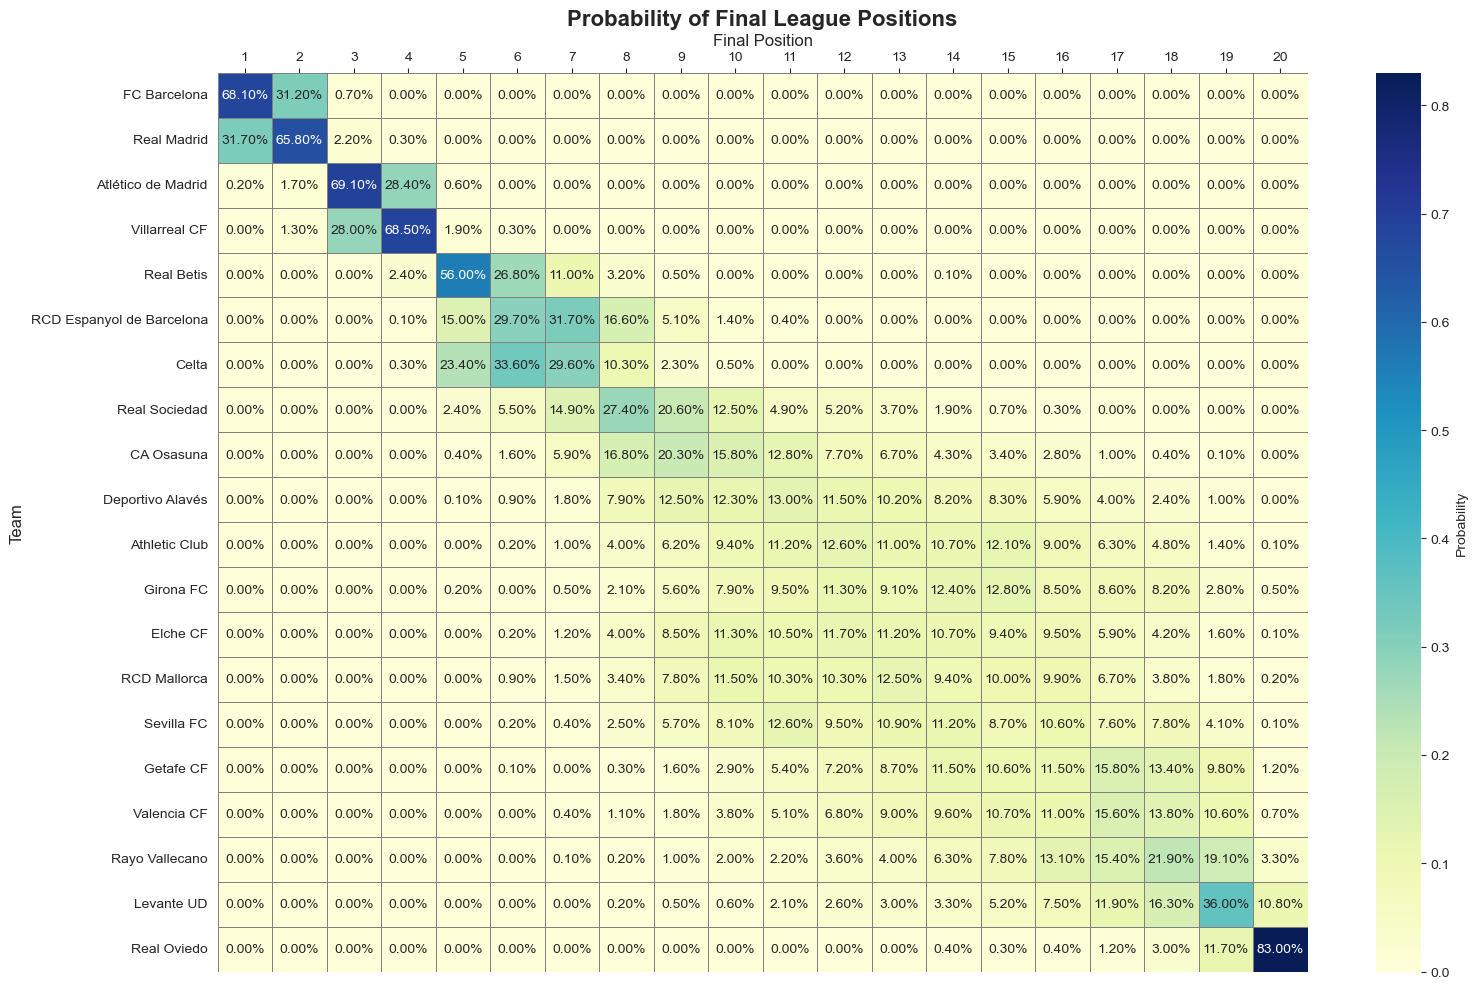

In [11]:
# Import visualization functions
from src.visualization import (
    plot_position_probabilities_heatmap,
    plot_team_position_distribution,
    plot_multiple_teams_distribution,
)

# Create heatmap visualization
plot_position_probabilities_heatmap(position_probs)

## 7. Detailed Team Analysis

Generate detailed statistics for each team's expected final position.

In [12]:
# Generate team statistics report
team_names = current_league_table["Team"].tolist()
team_stats_report = {}

for team in team_names:
    team_stats_report[team] = get_team_final_position_stats(position_probs, team)

# Create a DataFrame for better visualization
stats_df = pd.DataFrame(team_stats_report).T
stats_df = stats_df.sort_values("most_likely_position")

print("Team Final Position Statistics:\n")
print(stats_df)

Team Final Position Statistics:

                           most_likely_position  most_likely_prob  \
FC Barcelona                                1.0             0.681   
Real Madrid                                 2.0             0.658   
Atlético de Madrid                          3.0             0.691   
Villarreal CF                               4.0             0.685   
Real Betis                                  5.0             0.560   
Celta                                       6.0             0.336   
RCD Espanyol de Barcelona                   7.0             0.317   
Real Sociedad                               8.0             0.274   
CA Osasuna                                  9.0             0.203   
Sevilla FC                                 11.0             0.126   
Deportivo Alavés                           11.0             0.130   
Elche CF                                   12.0             0.117   
Athletic Club                              12.0             0.126   
R

## 8. Top Teams Analysis

Compare position distributions for top teams.

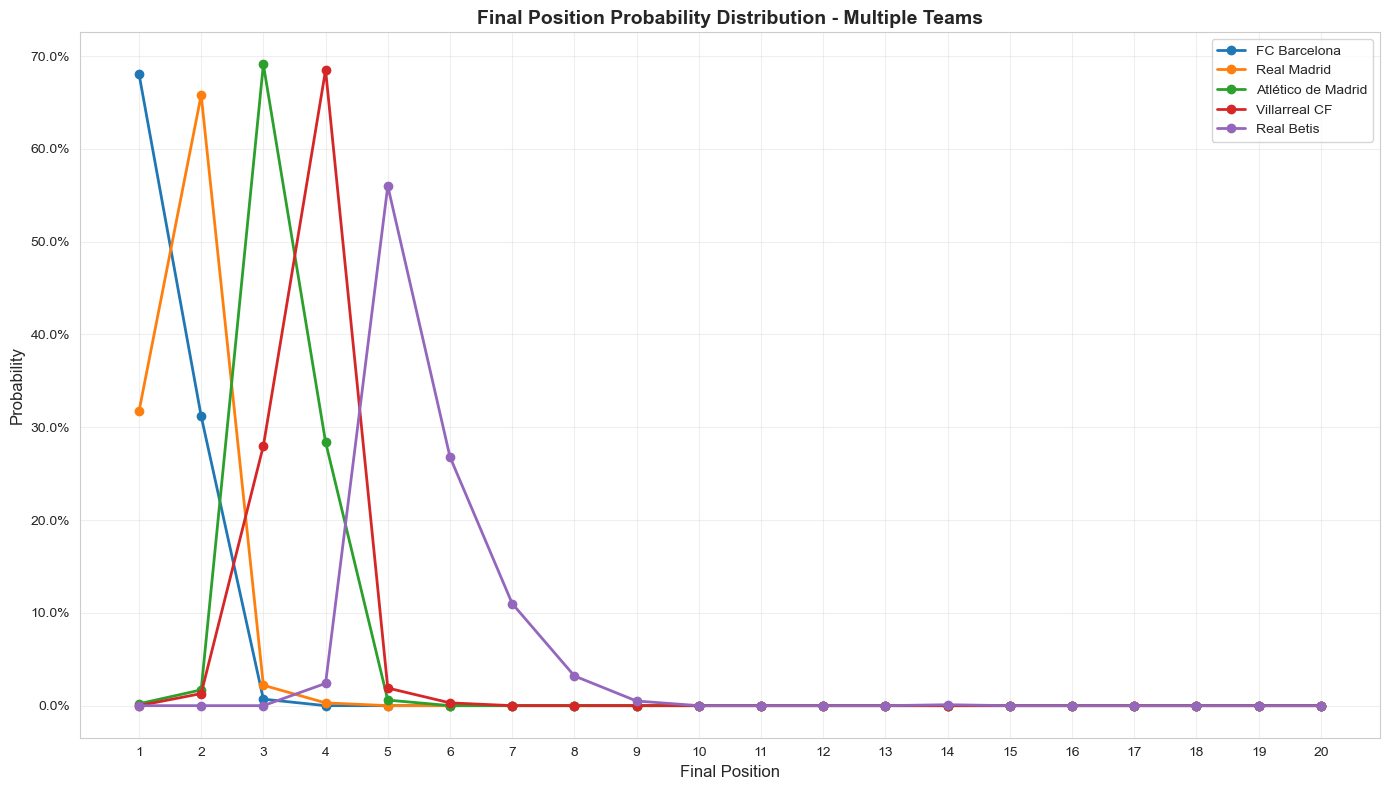

In [13]:
# Analyze top 5 teams
top_5_teams = current_league_table.head(5)["Team"].tolist()

plot_multiple_teams_distribution(position_probs, top_5_teams)

## 9. Summary and Conclusions

Key findings from the Monte Carlo simulation.

In [14]:
# Summary statistics
print(f"League: {config['league']['name']}")
print(f"Season: {config['league']['current_season']}")
print(f"Monte Carlo Simulations: {n_simulations}")
print()

print("Championship Probabilities (Top 3):")
for i, team in enumerate(stats_df.head(3).index, 1):
    prob = position_probs.loc[team, 1]
    print(f"{i}. {team}: {prob:.2%}")

print("\nRelegation Zone Probabilities (Bottom 3):")
n_positions = len(position_probs.columns)
for team in stats_df.tail(3).index:
    prob_bottom_3 = position_probs.loc[team, n_positions - 2 : n_positions].sum()
    print(f"{team}: {prob_bottom_3:.2%}")

League: La Liga
Season: 2025
Monte Carlo Simulations: 1000

Championship Probabilities (Top 3):
1. FC Barcelona: 68.10%
2. Real Madrid: 31.70%
3. Atlético de Madrid: 0.20%

Relegation Zone Probabilities (Bottom 3):
Rayo Vallecano: 44.30%
Levante UD: 63.10%
Real Oviedo: 97.70%
